### Testing generalization to eval dataset (transform_coltrane_2021_07_28_1.h5)

In [1]:
import os
import logging
# Send logging outputs to stdout (comment this out if preferred)
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)
from tqdm import tqdm

# Change this to egl or glfw if available
os.environ["MUJOCO_GL"] = "egl"

from track_mjx.agent import checkpointing
from track_mjx.analysis import rollout, render, utils
from track_mjx.environment import wrappers
from typing import Dict, Callable
import numpy as np
import jax
from brax.envs.base import Env
from track_mjx.environment.walker.rodent import Rodent
from track_mjx.environment.walker.fly import Fly
from brax import envs
from typing import Dict, Callable
import hydra
import logging
from track_mjx.environment.task.reward import RewardConfig
from jax import numpy as jnp

from track_mjx.environment.task.multi_clip_tracking import MultiClipTracking
from track_mjx.environment.task.single_clip_tracking import SingleClipTracking
from track_mjx.environment import wrappers
from track_mjx.io import load

from matplotlib import pyplot as plt

from omegaconf import DictConfig
from pathlib import Path

# don't preallocate jax memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card4: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card3: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card2: Permission denied

libEGL warning: egl: failed to create dri2 screen
libEGL warning: failed to open /dev/dri/card1: Permission denied



In [2]:
eval_data_path = "/n/holylabs/LABS/olveczky_lab/Users/charleszhang/stac-mjx/transform_coltrane_2021_07_28_1.h5"
n_frames_per_clip=250
# eval_data_path = "/n/holylabs/LABS/olveczky_lab/Users/charleszhang/track-mjx/data/transform_snips.h5"
# n_frames_per_clip=250
# replace with your checkpoint path
ckpt_path = "/n/holylabs/LABS/olveczky_lab/Users/charleszhang/track-mjx/model_checkpoints/250308_155205"  
# Load config from checkpoint 
ckpt = checkpointing.load_checkpoint_for_eval(ckpt_path)

cfg = ckpt["cfg"]

# make some changes to the config
# replace with absolute path to your data
# -- your notebook may not have access to the same relative path
cfg.data_path = "/n/holylabs/LABS/olveczky_lab/Users/charleszhang/track-mjx/data/transform_snips.h5"
cfg.train_setup.checkpoint_to_restore = ckpt_path

In [3]:
inference_fn = checkpointing.load_inference_fn(cfg, ckpt["policy"], get_activation=False)
reference_clip = load.make_multiclip_data(eval_data_path, n_frames_per_clip=n_frames_per_clip)
reference_clip.position.shape

(2160, 250, 3)

create env with test set reference clips

In [4]:
envs.register_environment("rodent_multi_clip", MultiClipTracking)

env_args = cfg["env_config"]["env_args"]
env_rewards = cfg["env_config"]["reward_weights"]
walker_config = cfg["walker_config"]
traj_config = cfg["reference_config"]

walker = Rodent(**walker_config)

reward_config = RewardConfig(**env_rewards)
# Automatically match dict keys and func needs
env = envs.get_environment(
    env_name="rodent_multi_clip",
    reference_clip=reference_clip,
    walker=walker,
    reward_config=reward_config,
    **env_args,
    **traj_config,
)

env._steps_for_cur_frame: 2.0


In [5]:
rollout_env = wrappers.RenderRolloutWrapperMulticlipTracking(env)

In [6]:
# vmap wrapper and auto align wrapper
align_vmap_env = wrappers.AutoAlignWrapperTracking(
        wrappers.RenderRolloutVmapWrapper(rollout_env)
    )
align_reset = align_vmap_env.reset 
align_step = align_vmap_env.step

In [7]:
# JIT-compile the necessary functions
jit_inference_fn = jax.jit(jax.vmap(inference_fn))
jit_align_reset = jax.jit(align_reset)
jit_align_step = jax.jit(align_step)


### transform data to multiclip, then initialize to multiclip with a long clip length (5000)

In [18]:
# autoalign wrapper rollout, 20 envs at a time
all_metrics = {
    "reward": [],
    "done": [],
}
num_envs = 500
for i in range(min(reference_clip.position.shape[0] // num_envs, 20)):
    print(f"clips {i * num_envs} to {i * num_envs + num_envs}")
    
    key_envs = jax.random.split(jax.random.PRNGKey(0), num_envs)

    clip_idxs = jnp.arange(0, num_envs) + i * num_envs

    init_states = jit_align_reset(key_envs, clip_idx=clip_idxs)
    num_steps = (
        int(n_frames_per_clip * env._steps_for_cur_frame) - 1
    ) 

    # rollouts = [init_states]
    state = init_states
    # activations = []
    rng_policy = jax.random.split(jax.random.PRNGKey(1), num_envs)

    for i in tqdm(range(num_steps)):
        rng_policy = jax.vmap(jax.random.split)(rng_policy)[:, 1, :]
        ctrl, extras = jit_inference_fn(state.obs, rng_policy)
        # activations.append(extras["activations"])
        state = jit_align_step(state, ctrl)
        # rollouts.append(state)
        all_metrics["reward"].append(state.reward)
        all_metrics["done"].append(state.metrics["done"])
        

clips 0 to 500


100%|██████████| 499/499 [00:32<00:00, 15.25it/s]


clips 500 to 1000


100%|██████████| 499/499 [00:32<00:00, 15.24it/s]


clips 1000 to 1500


100%|██████████| 499/499 [00:32<00:00, 15.25it/s]


clips 1500 to 2000


100%|██████████| 499/499 [00:32<00:00, 15.25it/s]


In [19]:
reshaped_dones = np.array(all_metrics["done"]).reshape(-1, order="F")
reshaped_rewards = np.array(all_metrics["reward"]).reshape(-1, order="F")
reshaped_rewards.shape

(998000,)

In [20]:
# avg reward: 
reshaped_rewards.mean()

np.float32(2.8125448)

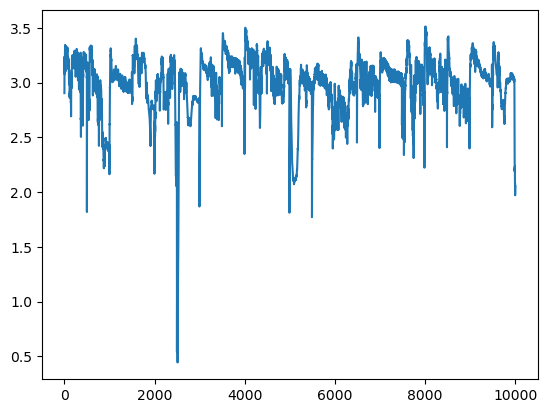

In [21]:
# plot reward over time, with smoothing
plt.plot(reshaped_rewards[:10000])

In [22]:
# calculate the number of done frames per hour
done_count = reshaped_dones.sum()
dones_per_hour = done_count * (3600 / (reshaped_dones.size / 100))  # Scale up to per hour
dones_per_hour



np.float32(284.60922)

In [13]:
# render rollouts
# rollout_dict = {
#     "qposes_ref": [r.pipeline_state.qpos[0] for r in rollouts], # set this as the mocap qpos
#     "qposes_rollout": [r.pipeline_state.qpos[0] for r in rollouts]
# }
# frames, realtime_framerate = render.render_rollout(cfg, rollout_dict)
# render.display_video(frames, framerate=realtime_framerate)